In [1]:
import matplotlib.pylab as plt 
%matplotlib inline
import numpy as np
import rubin_sim.maf_proto as maf
import pandas as pd
import sqlite3
import healpy as hp
import copy

from rubin_sim.data import get_baseline
from os.path import basename

In [2]:
# Read in the current baseline
db_file = get_baseline()
run_name = basename(db_file).replace('.db', '')
con = sqlite3.connect(db_file)
df = pd.read_sql('select * from observations;', con)
con.close()
# Convert to a numpy array
visits_array = df.to_records(index=False)


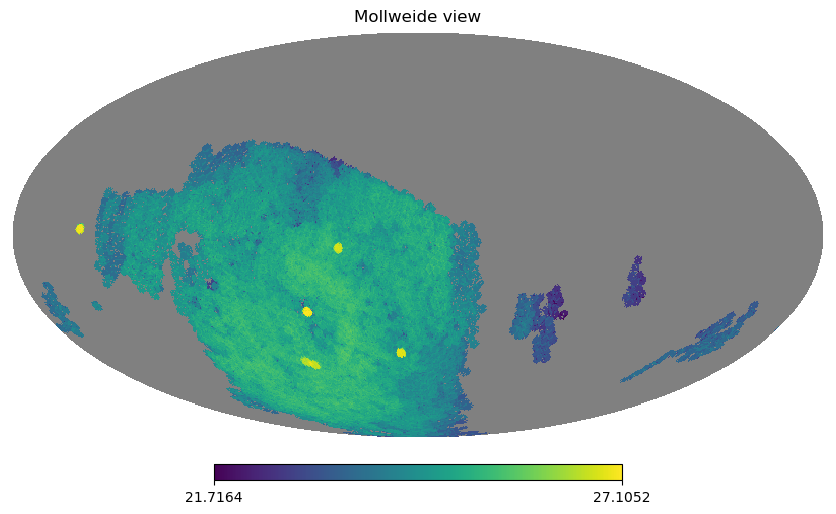

In [3]:
# Quick Coadded depth in r-band
sub_data = visits_array[np.where((visits_array["filter"] == "r") & (visits_array["night"] < 61))]
sl = maf.Slicer()
metric = maf.CoaddM5Metric("r")
hp_array = sl(sub_data, metric)
hp.mollview(hp_array)

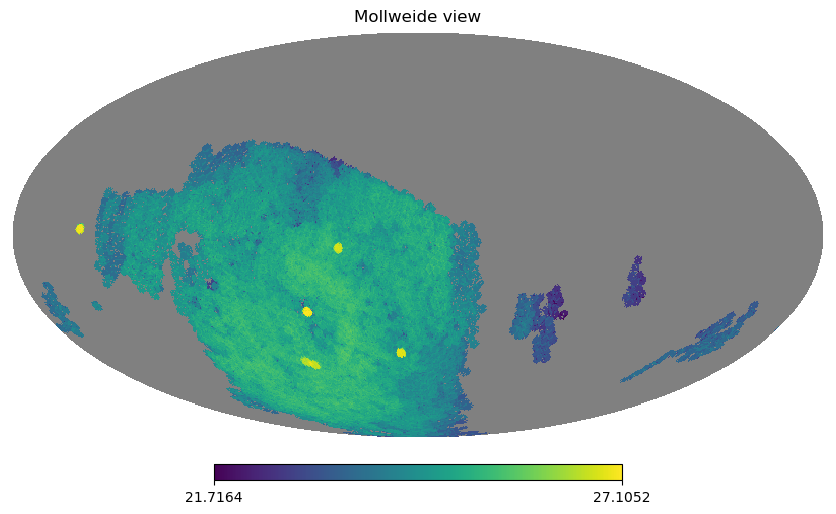

In [4]:
# Same as above, but can be done as a 1-liner!
hp.mollview(maf.Slicer()(visits_array[np.where((visits_array["filter"] == "r") &
                                               (visits_array["night"] < 61))],
                         maf.CoaddM5Metric("r")))


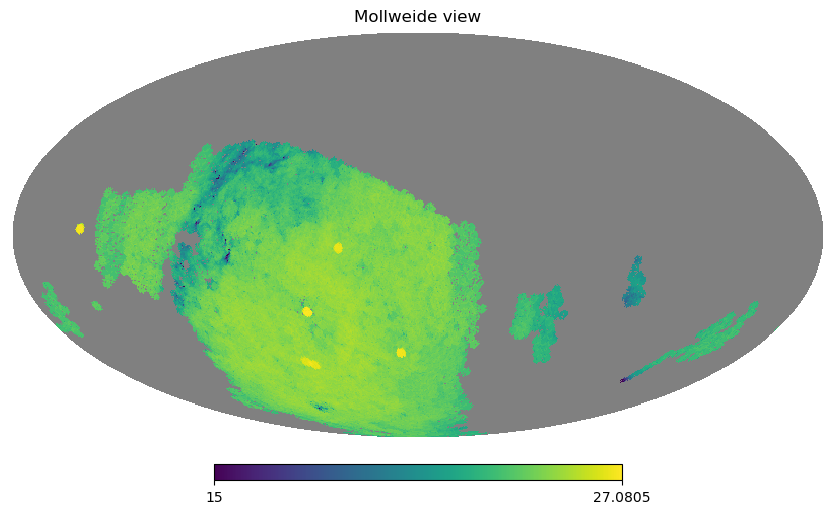

In [5]:
# Now with dust extintion, no Maps objects!
hp.mollview(maf.Slicer()(visits_array[np.where((visits_array["filter"] == "r") &
                                               (visits_array["night"] < 61))],
                         maf.CoaddM5ExtinctionMetric("r")), min=15)


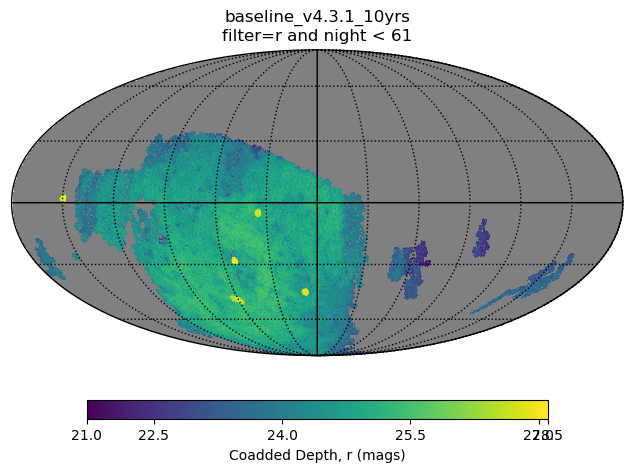

In [6]:
# Same coadded depth map, Now tracking relevant steps in a dict
# using PlotMoll to make the plot, and FigSaver to save it.
# Also computing a summary statistic

fig_saver = maf.FigSaver(close_figs=False)
# If we want to use some automated label generation 
info = {"run_name": run_name}
filtername = "r"
night_limit = 61
sub_data = visits_array[np.where((visits_array["filter"] == filtername) & (visits_array["night"] < night_limit))]
info['observations_subset'] = "filter=%s and night < %i" % (filtername, night_limit)
sl = maf.Slicer()
metric = maf.CoaddM5Metric("r")
# Run the metics through the slicer
hp_array, info = sl(sub_data, metric, info=info)
pm = maf.PlotMoll(info=info)
fig = pm(hp_array)
# To save a fig
fig_saver(fig, info)
# Compute a summary stat
summary_row = maf.gen_summary_row(info, "median", np.nanmedian(hp_array))


In [7]:
# Pretty output of the summary stat
pd.Series(summary_row).to_frame().T

,run_name,observations_subset,slicer: nside,metric: name,metric: col,metric: unit,summary_name,value
0,baseline_v4.3.1_10yrs,filter=r and night < 61,128,CoaddM5Metric,fiveSigmaDepth,"Coadded Depth, r (mags)",median,24.729426


In [8]:
# If we want the median slewtime
info = {"run_name": run_name, "observation_subset": "all"}
summary_row = maf.gen_summary_row(info, "median slewtime", np.median(visits_array["slewTime"]))
pd.Series(summary_row).to_frame().T


,run_name,observation_subset,summary_name,value
0,baseline_v4.3.1_10yrs,all,median slewtime,5.025164


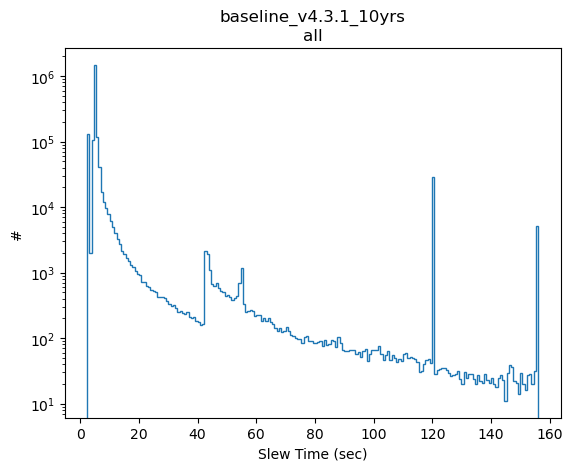

In [9]:
# Plot a histogram of slewtimes
info = {"run_name": run_name, "metric: unit": "Slew Time (sec)", 
        "observations_subset": "all", "metric: name": "slew time"}
ph = maf.PlotHist(info=info)
fig = ph(visits_array["slewTime"], log=True)
fig_saver(fig, info)

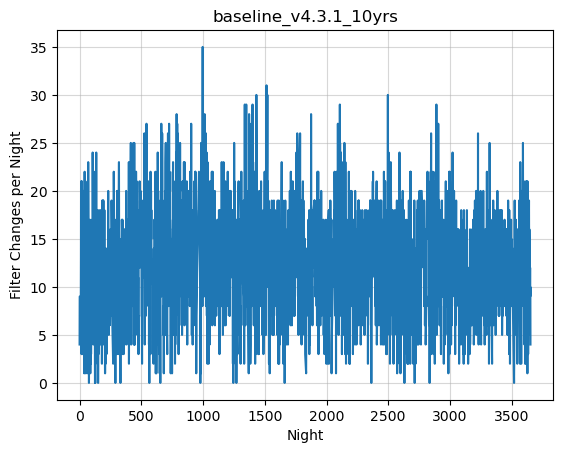

In [10]:
# If we want to compute something per night, use pandas group by
info = {"run_name": run_name, "metric: name": "filter changes"}
fpn = df.groupby("night")["filter"].apply(maf.count_value_changes)
pl = maf.PlotLine(info=info)
fig = pl(fpn.index, fpn.values, xlabel="Night", ylabel="Filter Changes per Night")
fig_saver(fig, info=info)

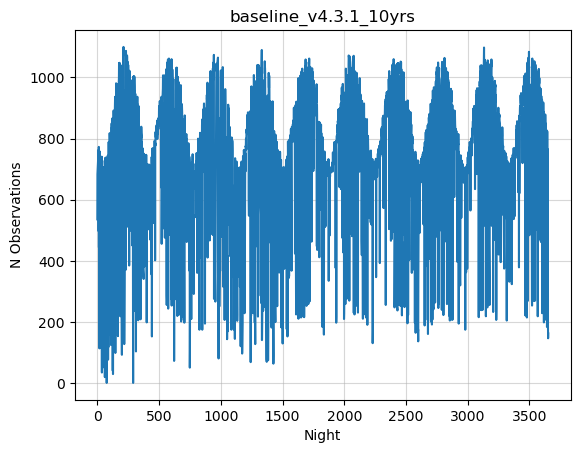

In [11]:
# Obsevations per night
info = {"run_name": run_name, "metric: name": "N Obs"}
fpn = df.groupby("night")["filter"].apply(np.size)
pl = maf.PlotLine(info=info)
fig = pl(fpn.index, fpn.values, xlabel="Night", ylabel="N Observations")
fig_saver(fig, info=info)

Loading  /Users/yoachim/rubin_sim_data/maf/SNe_data/LC_-2.0_0.2_380.0_800.0_ebvofMW_0.0_vstack.hdf5 g 20774 799 26


/Users/yoachim/anaconda3/envs/rubin12/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:868: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


Loading  /Users/yoachim/rubin_sim_data/maf/SNe_data/LC_-2.0_0.2_380.0_800.0_ebvofMW_0.0_vstack.hdf5 i 78302 799 98
Loading  /Users/yoachim/rubin_sim_data/maf/SNe_data/LC_-2.0_0.2_380.0_800.0_ebvofMW_0.0_vstack.hdf5 r 50337 799 63
Loading  /Users/yoachim/rubin_sim_data/maf/SNe_data/LC_-2.0_0.2_380.0_800.0_ebvofMW_0.0_vstack.hdf5 y 63121 799 79
Loading  /Users/yoachim/rubin_sim_data/maf/SNe_data/LC_-2.0_0.2_380.0_800.0_ebvofMW_0.0_vstack.hdf5 z 73508 799 92
Loading  /Users/yoachim/rubin_sim_data/maf/SNe_data/LC_0.0_0.0_380.0_800.0_ebvofMW_0.0_vstack.hdf5 g 20774 799 26


/Users/yoachim/anaconda3/envs/rubin12/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:868: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


Loading  /Users/yoachim/rubin_sim_data/maf/SNe_data/LC_0.0_0.0_380.0_800.0_ebvofMW_0.0_vstack.hdf5 i 78302 799 98
Loading  /Users/yoachim/rubin_sim_data/maf/SNe_data/LC_0.0_0.0_380.0_800.0_ebvofMW_0.0_vstack.hdf5 r 50337 799 63
Loading  /Users/yoachim/rubin_sim_data/maf/SNe_data/LC_0.0_0.0_380.0_800.0_ebvofMW_0.0_vstack.hdf5 y 78302 799 98
Loading  /Users/yoachim/rubin_sim_data/maf/SNe_data/LC_0.0_0.0_380.0_800.0_ebvofMW_0.0_vstack.hdf5 z 88689 799 111


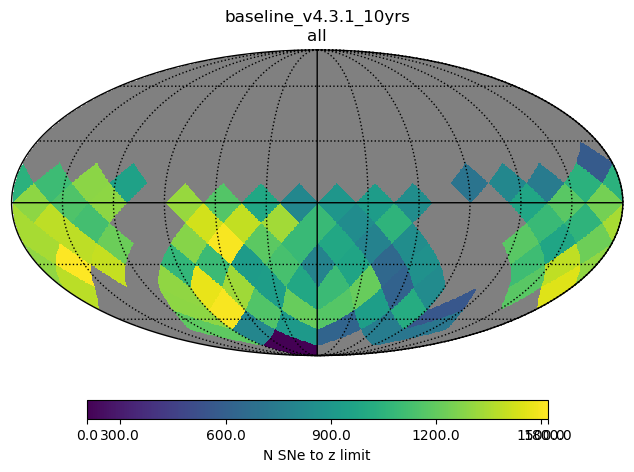

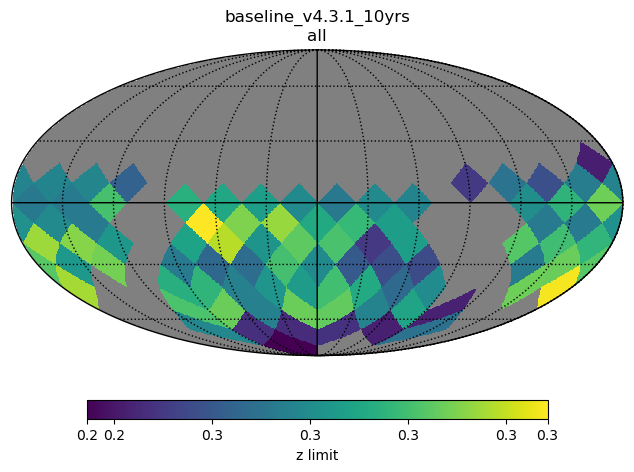

In [12]:
# The SNe metric that computes multiple things
summary_stats = []
nside = 4

info = maf.empty_info()
info["run_name"] = run_name
info["observations_subset"] = "all"
sl = maf.Slicer(nside=nside)
metric = maf.SNNSNMetric()
sn_array, info = sl(visits_array, metric, info=info)
pm = maf.PlotMoll(info=info)

# Need to split the info dict so 
# files don't clobber
metric_basename = info["metric: name"]
fig = pm(sn_array["n_sn"], unit="N SNe to z limit")
info["metric: name"] = metric_basename + " N SN"
fig_saver(fig, info=info)
fig = pm(sn_array["zlim"], unit="z limit")
info["metric: name"] = metric_basename + " z lim"
fig_saver(fig, info=info)

summary_stats.append(maf.gen_summary_row(info, "sum N SNe", np.nansum(sn_array["n_sn"])))
summary_stats.append(maf.gen_summary_row(info, "mean z limit", np.nanmean(sn_array["zlim"])))
summary_stats.append(maf.gen_summary_row(info, "median z limit", np.nanmedian(sn_array["zlim"])))


In [13]:
# Pretty output of summary stats
pd.DataFrame.from_dict(summary_stats)

,run_name,metric: name,metric: col,observations_subset,slicer: nside,summary_name,value,caption
0,baseline_v4.3.1_10yrs,SNNSNMetric z lim,,all,4,sum N SNe,92753.148060,
1,baseline_v4.3.1_10yrs,SNNSNMetric z lim,,all,4,mean z limit,0.283610,
2,baseline_v4.3.1_10yrs,SNNSNMetric z lim,,all,4,median z limit,0.282537,


In [14]:
# If we need some new columns, say for astrometry calculations
df["ra_pi_amp"], df["dec_pi_amp"] = maf.parallax_amplitude(
    df["fieldRA"].values, df["fieldDec"].values, df["observationStartMJD"].values, degrees=True
)

df["ra_dcr_amp"], df["dec_dcr_amp"] = maf.dcr_amplitude(
    90.0 - df["altitude"].values, df["paraAngle"].values, df["filter"].values, degrees=True
)
# Dump to numpy again for speed
visits_array = df.to_records(index=False)

/Users/yoachim/anaconda3/envs/rubin12/lib/python3.12/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "utctai" yielded 1387082 of "dubious year (Note 3)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/Users/yoachim/anaconda3/envs/rubin12/lib/python3.12/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "taiutc" yielded 1387082 of "dubious year (Note 4)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)


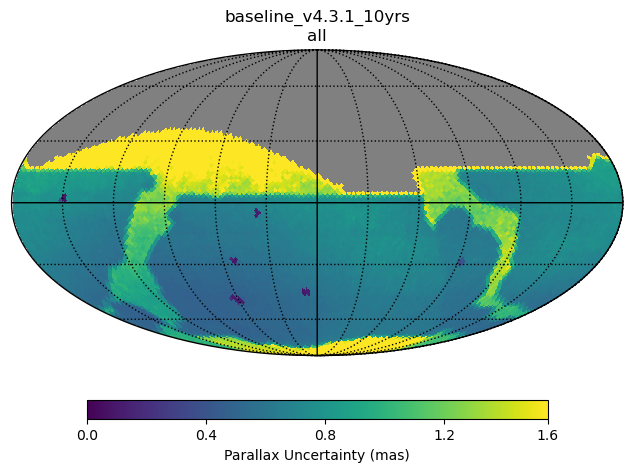

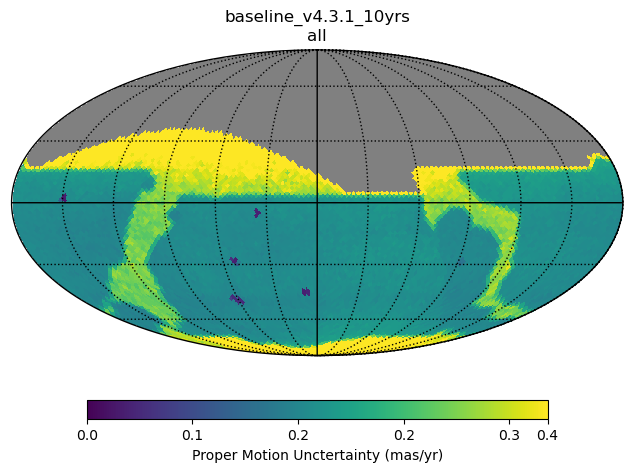

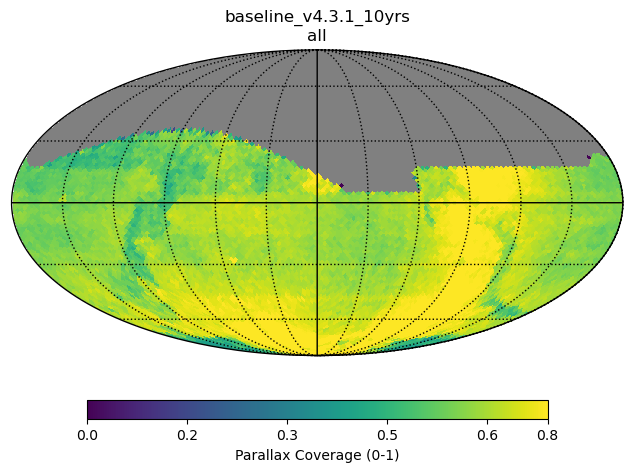

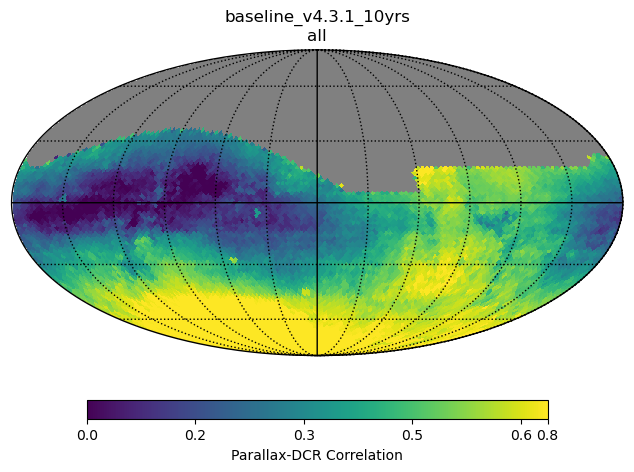

In [15]:
# Run multiple metrics at the same time in a slicer
metrics = []
metrics.append(maf.ParallaxMetric())
metrics.append(maf.ProperMotionMetric())
metrics.append(maf.ParallaxCoverageMetric())
metrics.append(maf.ParallaxDcrDegenMetric())

infos = []
for m in metrics:
    info = maf.empty_info()
    info["run_name"] = run_name
    info["observations_subset"] = "all"
    infos.append(info)

sl = maf.Slicer(nside=32)
hp_arrays, infos = sl(visits_array, metrics, info=infos)

for hp_array, info in zip(hp_arrays, infos):
    pm = maf.PlotMoll(info=info)
    fig = pm(hp_array, min=0, max=np.percentile(hp_array[np.isfinite(hp_array)], 90))
    fig_saver(fig, info=info)


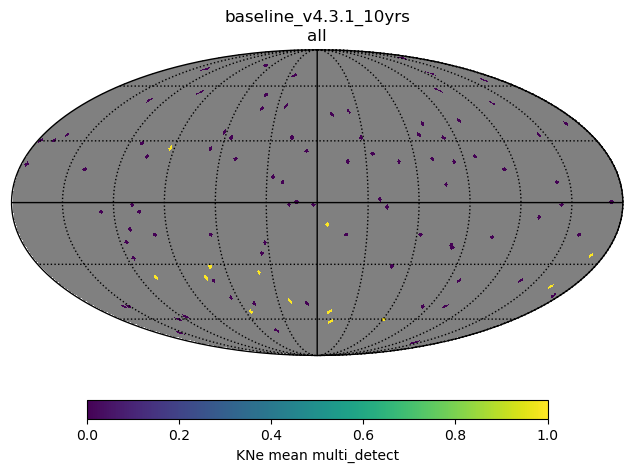

In [16]:
# Run a Monte Carlo over a list of objects
info = {"run_name": run_name, "observations_subset": "all"}
mjd0 = np.min(visits_array["observationStartMJD"])
metric = maf.KNePopMetric(mjd0=mjd0)
metric.generate_kn_pop(n_events=100)
sl = maf.Slicer(nside=None, missing=0, ra=np.degrees(metric.ra), dec=np.degrees(metric.dec))
kn_array, info = sl(visits_array, metric, info=info)
ph = maf.PlotHealbin(info=info)
fig = ph(
        np.degrees(metric.ra),
        np.degrees(metric.dec),
        kn_array["multi_detect"],
        unit="KNe mean multi_detect"
    )
info["metrid: name"] = "KNe multi_detect"
#fig_saver(fig, info=info)
summary_stats = []
for key in kn_array.dtype.names:
    summary_stats.append(maf.gen_summary_row(info, "Mean KNe " + key, np.mean(kn_array[key])))
    summary_stats.append(
        maf.gen_summary_row(
            info, "Uncert in Mean KNe " + key, np.mean(kn_array[key]) / np.sqrt(np.sum(kn_array[key]))
        )
    )

In [17]:
pd.DataFrame(summary_stats)

,run_name,observations_subset,slicer: nside,metric: name,metric: col,metric: unit,metrid: name,summary_name,value
0,baseline_v4.3.1_10yrs,all,None,KNePopMetric,None,"Detected, 0 or 1",KNe multi_detect,Mean KNe multi_detect,0.130000
1,baseline_v4.3.1_10yrs,all,None,KNePopMetric,None,"Detected, 0 or 1",KNe multi_detect,Uncert in Mean KNe multi_detect,0.036056
2,baseline_v4.3.1_10yrs,all,None,KNePopMetric,None,"Detected, 0 or 1",KNe multi_detect,Mean KNe ztfrest_simple,0.020000
3,baseline_v4.3.1_10yrs,all,None,KNePopMetric,None,"Detected, 0 or 1",KNe multi_detect,Uncert in Mean KNe ztfrest_simple,0.014142
4,baseline_v4.3.1_10yrs,all,None,KNePopMetric,None,"Detected, 0 or 1",KNe multi_detect,Mean KNe ztfrest_simple_red,0.020000
5,baseline_v4.3.1_10yrs,all,None,KNePopMetric,None,"Detected, 0 or 1",KNe multi_detect,Uncert in Mean KNe ztfrest_simple_red,0.014142
6,baseline_v4.3.1_10yrs,all,None,KNePopMetric,None,"Detected, 0 or 1",KNe multi_detect,Mean KNe ztfrest_simple_blue,0.010000
7,baseline_v4.3.1_10yrs,all,None,KNePopMetric,None,"Detected, 0 or 1",KNe multi_detect,Uncert in Mean KNe ztfrest_simple_blue,0.010000
8,baseline_v4.3.1_10yrs,all,None,KNePopMetric,None,"Detected, 0 or 1",KNe multi_detect,Mean KNe multi_color_detect,0.110000
9,baseline_v4.3.1_10yrs,all,None,KNePopMetric,None,"Detected, 0 or 1",KNe multi_detect,Uncert in Mean KNe multi_color_detect,0.033166


In [18]:
# Looking at things vs time
info = {"run_name": run_name}
times = np.arange(3653)
metric = maf.AccumulateCountMetric(times)
sl = maf.Slicer(nside=32, missing=0)
hp_time_array, info = sl(visits_array, metric, info=info)


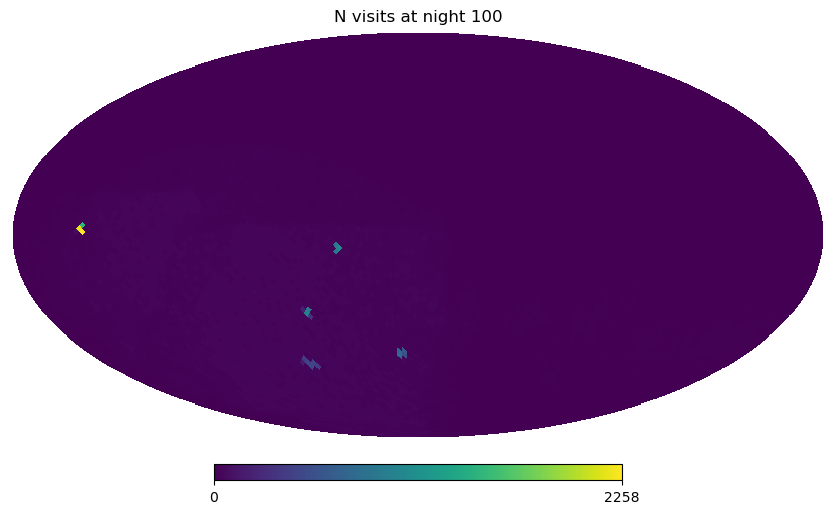

In [19]:
# take a peak that our array is now a vector at each healpix
# So if one wanted to make a movie, these could be the frames
hp.mollview(hp_time_array[:, 100], title="N visits at night 100")

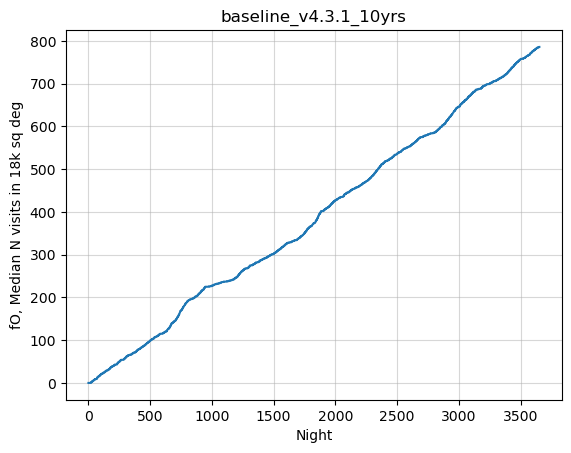

In [20]:
# Convert N obs in HEALpix vs time to fO vs time
fo_time = maf.fO_time_calcs(hp_time_array, asky=18000.0, n_visit=750, stat=np.median)
info = {"run_name": run_name, "metric: name": "fO v time"}
pl = maf.PlotLine(info=info)
fig = pl(times, fo_time, xlabel="Night", ylabel="fO, Median N visits in 18k sq deg")
fig_saver(fig, info=info)

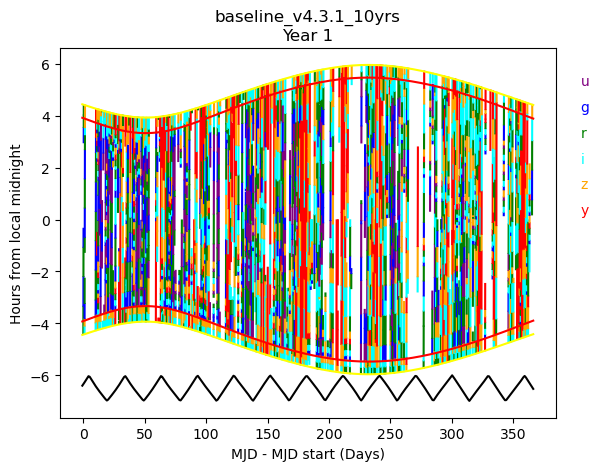

In [21]:
# The classic hourglass plot
info = {"run_name": run_name, "observations_subset": "Year 1", "metric: name": "Hourglass"}
indx = np.where(visits_array["night"] <= 365)
hr = maf.PlotHourglass(info=info)
fig = hr(visits_array[indx])
fig_saver(fig, info=info)

In [22]:
# Check out the directory FigSaver dumped things into
!ls maf_figs


CoaddM5Metric_fiveSigmaDepth_filter_r_and_night_lt_61_nside128.pdf
filter_changes.pdf
fO_v_time.pdf
Hourglass_Year_1.pdf
maf_tracking.db
N_Obs.pdf
ParallaxCoverageMetric_all_nside32.pdf
ParallaxDcrDegenMetric_all_nside32.pdf
ParallaxMetric_all_nside32.pdf
ProperMotionMetric_all_nside32.pdf
slew_time_all.pdf
SNNSNMetric_N_SN_all_nside4.pdf
SNNSNMetric_z_lim_all_nside4.pdf
thumb_CoaddM5Metric_fiveSigmaDepth_filter_r_and_night_lt_61_nside128.png
thumb_filter_changes.png
thumb_fO_v_time.png
thumb_Hourglass_Year_1.png
thumb_N_Obs.png
thumb_ParallaxCoverageMetric_all_nside32.png
thumb_ParallaxDcrDegenMetric_all_nside32.png
thumb_ParallaxMetric_all_nside32.png
thumb_ProperMotionMetric_all_nside32.png
thumb_slew_time_all.png
thumb_SNNSNMetric_N_SN_all_nside4.png
thumb_SNNSNMetric_z_lim_all_nside4.png


In [23]:
# Visits overlapping a single point
ra = 0
dec = -20
sl = maf.Slicer(ra=ra, dec=dec)
visits_at_point = sl(visits_array, maf.PassMetric())

/Users/yoachim/git_repos/rubin_sim/rubin_sim/maf_proto/slicers/slicers.py:90: UserWarning: Both nside and ra kwargs set, using ra setting nside=None.
  warnings.warn("Both nside and ra kwargs set, using ra setting nside=None.")


Text(0.5, 1.0, 'baseline_v4.3.1_10yrs\nObservations overlapping ra=0.000, dec=-20.000')

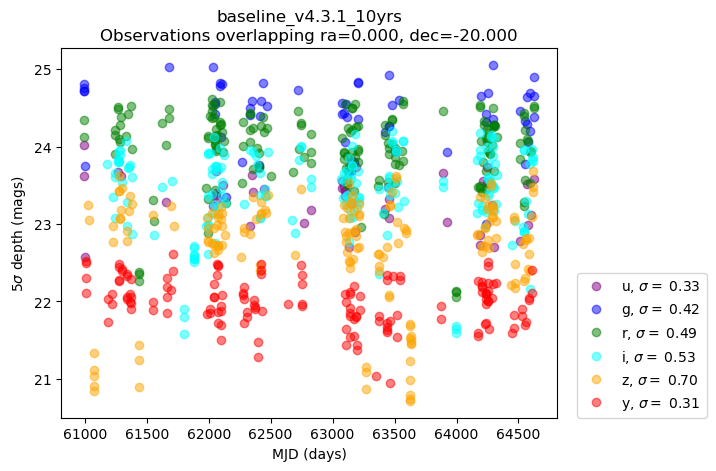

In [24]:
fig, ax = plt.subplots()
f2c = {'u': 'purple', 'g': 'blue', 'r': 'green',
       'i': 'cyan', 'z': 'orange', 'y': 'red'}
for fn in f2c:
    in_filt = np.where(visits_at_point['filter'] == fn)[0]
    ax.plot(visits_at_point['observationStartMJD'][in_filt],
             visits_at_point['fiveSigmaDepth'][in_filt], 'o',
             color=f2c[fn],
             label=fn+r', $\sigma=$ %.2f' % (np.std(visits_at_point['fiveSigmaDepth'][in_filt])),
             alpha=0.5)
ax.set_xlabel('MJD (days)')
ax.set_ylabel(r'5$\sigma$ depth (mags)')
ax.legend(loc=(1.04,0))
ax.set_title('%s\nObservations overlapping ra=%.3f, dec=%.3f' % (run_name, ra,dec))
